data profile

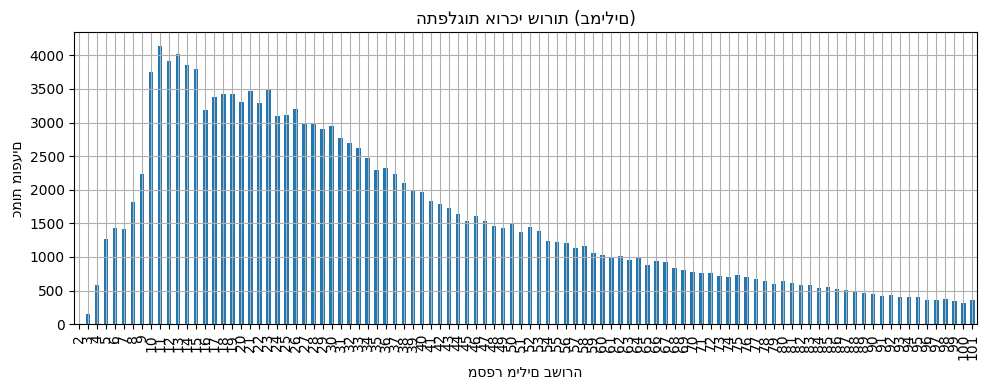


🗓 Top Dates:
0
29.10.2014    172
4.7.12        170
29.10.14      167
12.8.2018     161
22.6.2010     148
58-10-14      119
10-10-15      115
4.7.2012       98
24.7.2011      97
4.2.2021       95
Name: count, dtype: int64

🕵️‍♀️ Redacted Patterns:
0
פלוני            1533
xxxxxxxxxx        391
xxxxxxxxx         237
אלמוני             19
xxxxxxxx           10
xxxxxxxxxxx        10
xxxxxxxxxxxxx       9
XXX                 7
Name: count, dtype: int64

🆔 Top Long IDs:
0
54678313          10808
5129371            7189
35592               366
2055000             332
42358               115
28110               114
9787336             108
9787377             107
41827                72
51293715129371       61
Name: count, dtype: int64

🧪 תווים חריגים שזוהו (Top 20):
'(' — 93682 פעמים
')' — 93416 פעמים
''' — 67223 פעמים
'–' — 29766 פעמים
';' — 22796 פעמים
'₪' — 14769 פעמים
']' — 13680 פעמים
'[' — 13674 פעמים
'#' — 7198 פעמים
'>' — 3690 פעמים
'<' — 3511 פעמים
'+' — 2521 פעמים
'‏' — 1082 פעמים
'*

: 

In [ ]:
import os
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

# ===== קלט =====
CSV_DIR = "/home/liorkob/M.Sc/thesis/data/drugs_3k/verdict_csv"

all_texts = []

# ===== קריאת כל קובצי הטקסט =====
for fname in os.listdir(CSV_DIR):
    if fname.endswith(".csv"):
        df = pd.read_csv(os.path.join(CSV_DIR, fname))
        for _, row in df.iterrows():
            text = str(row.get("text", "")).strip().replace("\n", " ")
            part = str(row.get("part", "")).strip()
            if text:
                all_texts.append(f"{part}: {text}")

# ===== יצירת DataFrame לצורך חקירה =====
df_texts = pd.DataFrame({"text": all_texts})

# ===== 1. חקירת תבניות תאריכים =====
dates = df_texts["text"].str.extractall(r'(\d{1,2}[./-]\d{1,2}[./-]\d{2,4})')
date_counts = dates[0].value_counts().head(10)

# ===== 2. שמות מוסתרים =====
redacted = df_texts["text"].str.extractall(r'\b(x{3,}|X{3,}|אלמוני|פלוני)\b')
redacted_counts = redacted[0].value_counts()

# ===== 3. מספרים ארוכים (תיקים, ת"זים) =====
ids = df_texts["text"].str.extractall(r'(\d{5,})')
id_counts = ids[0].value_counts().head(10)

# ===== 4. אורך טקסט בשורות =====
df_texts["word_count"] = df_texts["text"].apply(lambda x: len(str(x).split()))
word_count_dist = df_texts["word_count"].value_counts().sort_index()

# ===== 5. תווים לא סטנדרטיים =====
all_chars = Counter("".join(df_texts["text"].dropna().astype(str)))
unusual_chars = sorted(
    [(c, n) for c, n in all_chars.items() if not re.match(r'[\u0590-\u05FF\dA-Za-z\s:/"\-.,]', c)],
    key=lambda x: -x[1]
)

# ===== הצגת גרף אורך שורות =====
plt.figure(figsize=(10, 4))
word_count_dist[:100].plot(kind="bar")
plt.title("התפלגות אורכי שורות (במילים)")
plt.xlabel("מספר מילים בשורה")
plt.ylabel("כמות מופעים")
plt.grid()
plt.tight_layout()
plt.show()

# ===== הצגת תוצאות טקסטואלית =====
print("\n🗓 Top Dates:")
print(date_counts)

print("\n🕵️‍♀️ Redacted Patterns:")
print(redacted_counts)

print("\n🆔 Top Long IDs:")
print(id_counts)

print("\n🧪 תווים חריגים שזוהו (Top 20):")
for c, n in unusual_chars[:20]:
    print(f"'{c}' — {n} פעמים")


data prep

In [ ]:
import os
import pandas as pd
import sentencepiece as spm
import shutil
import json

# ========= שלב 1: איסוף טקסטים מכל קובצי ה-CSV =========
CSV_DIR = "/home/liorkob/M.Sc/thesis/data/drugs_3k/verdict_csv"
output_txt_path = "verdict_corpus.txt"

all_texts = []
for fname in os.listdir(CSV_DIR):
    if fname.endswith(".csv"):
        df = pd.read_csv(os.path.join(CSV_DIR, fname))
        for _, row in df.iterrows():
            text = str(row.get("text", "")).strip().replace("\n", " ")
            part = str(row.get("part", "")).strip()
            if text:
                all_texts.append(f"{part}: {text}")

with open(output_txt_path, "w", encoding="utf8") as f:
    for line in all_texts:
        f.write(line + "\n")

print(f"✅ נשמרו {len(all_texts)} שורות ל־{output_txt_path}")


In [ ]:
import os
import sentencepiece as spm
from sentencepiece import sentencepiece_model_pb2
import json
import shutil

# ========== הגדרות ==========
input_file = "verdict_corpus.txt"
tokenizer_dir = "legal_tokenizer_spm"
model_prefix = os.path.join(tokenizer_dir, "spiece")
os.makedirs(tokenizer_dir, exist_ok=True)

# ========== חישוב גודל והתאמת vocab_size ==========
file_size_mb = os.path.getsize(input_file) / (1024 * 1024)

if file_size_mb < 10:
    vocab_size = 8000
elif file_size_mb < 50:
    vocab_size = 32000
elif file_size_mb < 150:
    vocab_size = 50000
else:
    vocab_size = 100000  # גדול במיוחד אם הקובץ עצום

print(f"📏 גודל קובץ: {file_size_mb:.2f}MB → vocab_size = {vocab_size}")

# ========== אימון ==========
spm.SentencePieceTrainer.Train(
    input=input_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    model_type="unigram",
    character_coverage=0.9995,
    user_defined_symbols=[f"<extra_id_{i}>" for i in range(100)],
    byte_fallback=True,
    train_extremely_large_corpus=(file_size_mb > 100)
)

# ========== שמירת tokenizer_config ==========
with open(os.path.join(tokenizer_dir, "tokenizer_config.json"), "w") as f:
    json.dump({
        "model_max_length": 512,
        "tokenizer_class": "T5Tokenizer"
    }, f)

# ========== יצירת קובץ vocab בפורמט טקסט ==========
model = sentencepiece_model_pb2.ModelProto()
model.ParseFromString(open(model_prefix + ".model", "rb").read())
with open(model_prefix + ".vocab", "w", encoding="utf-8") as f:
    for p in model.pieces:
        f.write(f"{p.piece}\t{p.score}\n")

print("✅ טוקנייזר נשמר בתיקייה:", tokenizer_dir)


📏 גודל קובץ: 71.91MB → vocab_size = 50000
✅ טוקנייזר נשמר בתיקייה: legal_tokenizer_spm


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: verdict_corpus.txt
  input_format: 
  model_prefix: legal_tokenizer_spm/spiece
  model_type: UNIGRAM
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <extra_id_0>
  user_defined_symbols: <extra_id_1>
  user_defined_symbols: <extra_id_2>
  user_defined_symbols: <extra_id_3>
  user_defined_symbols: <extra_id_4>
  user_defined_symbols: <extra_id_5>
  user_defined_symbols: <extra_id_6>
  user_defined_symbols: <extra_id_7>
  user_defined_symbols: <extra_id_8>


: 

In [1]:
import os
import pandas as pd
import sentencepiece as spm
import shutil
import json
# ===== הגדרות קלט =====
input_file = "verdict_corpus.txt"
model_prefix = "legal_tokenizer"
tokenizer_dir = "legal_tokenizer_spm"
vocab_size = 50000


# ===== אימון =====
spm.SentencePieceTrainer.Train(
    input=input_file,
    model_prefix="legal_tokenizer",
    vocab_size=vocab_size,
    model_type="unigram",
    character_coverage=0.9995
)

import os
import json
import shutil

os.makedirs("legal_tokenizer_spm", exist_ok=True)
shutil.copy("legal_tokenizer.model", "legal_tokenizer_spm/spiece.model")

with open("legal_tokenizer_spm/tokenizer_config.json", "w") as f:
    json.dump({
        "model_max_length": 512,
        "tokenizer_class": "T5Tokenizer"
    }, f)


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: verdict_corpus.txt
  input_format: 
  model_prefix: legal_tokenizer
  model_type: UNIGRAM
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_priv

In [ ]:
from tqdm import tqdm
from transformers import T5Tokenizer, MT5ForConditionalGeneration
import random
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()
import pandas as pd
import random
import re
from collections import Counter
from datasets import Dataset
from transformers import MT5Tokenizer, MT5ForConditionalGeneration, Trainer, TrainingArguments
import evaluate
import numpy as np
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# %env CUDA_LAUNCH_BLOCKING=1

import torch
from transformers import T5Tokenizer, MT5ForConditionalGeneration

from transformers import T5Tokenizer
from transformers import T5Tokenizer, MT5ForConditionalGeneration


tokenizer = T5Tokenizer.from_pretrained("legal_tokenizer_spm", legacy=False)
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-base")

# ✨ זה קריטי — מתאימים את embedding לגודל החדש
model.resize_token_embeddings(len(tokenizer))

# בדיקה
input_ids = tokenizer("הנאשם הורשע בסחר בסמים", return_tensors="pt").input_ids
print("Max token id:", input_ids.max().item())
print("Tokenizer size:", len(tokenizer))
print("Model embedding size:", model.get_input_embeddings().weight.shape[0])

df = pd.read_csv("/home/liorkob/M.Sc/thesis/data/drugs_3k/gpt/processed_verdicts_with_gpt.csv")
# ========== שלב 2: יצירת דוגמאות עם מסכה ==========
used_targets = set()

def mask_random_phrase(text, min_words=2, max_words=4):
    words = text.split()
    if len(words) < min_words:
        return None, None
    for _ in range(5):
        phrase_len = random.randint(min_words, min(max_words, len(words)))
        start = random.randint(0, len(words) - phrase_len)
        end = start + phrase_len
        masked = " ".join(words[start:end])
        input_text = " ".join(words[:start] + ["<extra_id_0>"] + words[end:])
        target_text = f"<extra_id_0> {masked} <extra_id_1>"
        if len(masked.strip().split()) >= 2 and target_text not in used_targets:
            used_targets.add(target_text)
            return input_text, target_text
    return None, None

def split_to_windows(text, tokenizer, max_length=256, stride=128):
    # input_ids = tokenizer.encode(text, add_special_tokens=False)
    windows = []
    input_ids = [t for t in tokenizer.encode(text, add_special_tokens=False) if t < len(tokenizer)]

    for i in range(0, len(input_ids), stride):
        window_ids = input_ids[i:i+max_length]
        if len(window_ids) < 10:
            continue
        window_text = tokenizer.decode(window_ids, skip_special_tokens=True)
        windows.append(window_text)
        if i + max_length >= len(input_ids):
            break
    return windows

masked_data = []
for _, row in df.iterrows():
    if pd.isna(row["extracted_gpt_facts"]):
        continue
    windows = split_to_windows(row["extracted_gpt_facts"], tokenizer)
    for window in windows:
        input_text, target_text = mask_random_phrase(window)
        if input_text and target_text:
            masked_data.append({
                "input_text": input_text,
                "target_text": target_text
            })

# ========== שלב 3: Dataset + פיצול ==========
df_masked = pd.DataFrame(masked_data)
dataset = Dataset.from_pandas(df_masked[["input_text", "target_text"]])
dataset = dataset.shuffle(seed=42)
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)

# ========== שלב 4: טוקניזציה עם תיקון ל-labels ==========
def tokenize(batch):
    input_enc = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=512)
    target_enc = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=20)
    labels = target_enc["input_ids"]
    labels = [[(token if token != tokenizer.pad_token_id else -100) for token in seq] for seq in target_enc["input_ids"]]

    # labels = [[(token if token != tokenizer.pad_token_id else -100) for token in seq] for seq in labels]
    input_enc["labels"] = labels
    return input_enc

tokenized_dataset = dataset_split.map(tokenize, batched=True)


def validate_tokenized_dataset(dataset, tokenizer, model):
    embedding_size = model.get_input_embeddings().weight.shape[0]
    pad_token_id = tokenizer.pad_token_id

    errors = {
        "input_ids_out_of_range": [],
        "labels_out_of_range": [],
        "labels_bad_pad_value": [],
    }

    for i, example in enumerate(tqdm(dataset)):
        # בדיקת input_ids
        for token in example["input_ids"]:
            if not (0 <= token < embedding_size):
                errors["input_ids_out_of_range"].append((i, token))
                break

        # בדיקת labels
        for token in example["labels"]:
            if token == pad_token_id:
                errors["labels_bad_pad_value"].append((i, token))
                break
            if token != -100 and not (0 <= token < embedding_size):
                errors["labels_out_of_range"].append((i, token))
                break

    print("\n🔎 סיכום בדיקות:")
    for key, items in errors.items():
        print(f"🚨 {key}: {len(items)} דוגמאות שגויות")

    return errors
errors = validate_tokenized_dataset(tokenized_dataset["train"], tokenizer, model)


ex = tokenized_dataset["train"][0]
print("Input text:", dataset["train"][0]["input_text"])
print("Target text:", dataset["train"][0]["target_text"])
print("Labels:", ex["labels"])
print("Label tokens:", tokenizer.convert_ids_to_tokens([t for t in ex["labels"] if t != -100]))


2025-06-18 13:57:50.629777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750244270.643989 2577389 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750244270.648283 2577389 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750244270.660715 2577389 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750244270.660729 2577389 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750244270.660732 2577389 computation_placer.cc:177] computation placer alr

Max token id: 1122
Tokenizer size: 50101
Model embedding size: 50101


Token indices sequence length is longer than the specified maximum sequence length for this model (1662 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1201 [00:00<?, ? examples/s]

100%|██████████| 4800/4800 [00:01<00:00, 3042.10it/s]



🔎 סיכום בדיקות:
🚨 input_ids_out_of_range: 0 דוגמאות שגויות
🚨 labels_out_of_range: 0 דוגמאות שגויות
🚨 labels_bad_pad_value: 0 דוגמאות שגויות


KeyError: "Column train not in the dataset. Current columns in the dataset: ['input_text', 'target_text']"

: 

In [2]:
print("\n🔍 300 הטוקנים הראשונים בטוקנייזר (ישירות מהtokenizer):")
vocab = list(tokenizer.get_vocab().items())
vocab_sorted = sorted(vocab, key=lambda x: x[1])  # לפי ID

for i, (tok, tok_id) in enumerate(vocab_sorted[:300]):
    print(f"{tok_id:5} : {tok}")



🔍 300 הטוקנים הראשונים בטוקנייזר (ישירות מהtokenizer):
    0 : <unk>
    1 : <s>
    2 : </s>
    3 : ,
    4 : .
    5 : :
    6 : ▁הנאשם
    7 : ▁של
    8 : "
    9 : ▁על
   10 : ▁
   11 : ▁את
   12 : ▁כי
   13 : ▁מאסר
   14 : '
   15 : ▁ב
   16 : ▁(
   17 : ▁שירות
   18 : ▁העונש
   19 : ▁ו
   20 : ▁המבחן
   21 : ▁מתחם
   22 : ה
   23 : ▁ל
   24 : ▁לא
   25 : פ
   26 : ▁חודשי
   27 : )
   28 : ▁נ
   29 : ▁הסמים
   30 : ו
   31 : ▁ישראל
   32 : ▁מדינת
   33 : -
   34 : ▁ההולם
   35 : ▁–
   36 : ▁סם
   37 : ▁גזר
   38 : ▁המשפט
   39 : ▁בית
   40 : ▁בפועל
   41 : ▁דין
   42 : ג
   43 : ▁זה
   44 : ▁סמים
   45 : ▁הוא
   46 : ▁מסוג
   47 : ▁דיון
   48 : ▁מ
   49 : ת
   50 : ▁עם
   51 : ▁אשר
   52 : ▁בין
   53 : כ
   54 : ▁הענישה
   55 : א
   56 : ▁הצדדים
   57 : ▁ש
   58 : ▁האישום
   59 : ;
   60 : ▁שלא
   61 : ▁והכרעה
   62 : ▁העבירה
   63 : ▁או
   64 : י
   65 : ▁יש
   66 : ▁לעונש
   67 : ים
   68 : ▁המאשימה
   69 : ▁גרם
   70 : ▁לנאשם
   71 : ▁עבירות
   72 : ▁חודשים
   73 : ▁עונש
   7